**Importing the required libraries**

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

**Importing the Deep Learning and ML libraries**

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
from keras.utils import np_utils
from keras.models import Sequential
from keras.callbacks import EarlyStopping, History, ModelCheckpoint
from keras.layers.core import Flatten, Dense, Dropout, Reshape, Lambda
from keras.layers.normalization import BatchNormalization

In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split

In [ ]:
import numpy as np

**Loading the preprocessed training and validation set features**

In [ ]:
train_features = np.load('train_preprocesed.npy')
valid_features = np.load('valid_preprocessed.npy')

**Setting the directories for loading the training and validation set images**

In [ ]:
train_dir = "new_train\\"
valid_dir = "new_valid\\"

**Obtaining the class names from the training set images**

In [ ]:
classes = os.listdir(train_dir)

**Retrieving the labels associated with each of the training set images**

In [ ]:
# Get the labels

train_labels = []
for c in classes:
    l = [c]*len(os.listdir(train_dir+c+'\\'))
    train_labels.extend(l)

**Displaying the length of the training set labels**

In [ ]:
len(train_labels)

3019

**Obtaining the labels associated with each of the validation set images**

In [ ]:
valid_labels = []

for c in classes:
    l = [c]*len(os.listdir(valid_dir+c+'\\'))
    valid_labels.extend(l)

**Displaying the length of the valid set labels**

In [ ]:
len(valid_labels)

758

**Encoding the training labels**

In [ ]:
onehot_train = to_categorical(LabelEncoder().fit_transform(train_labels))

**Encoding the validation set labels**

In [ ]:
onehot_valid = to_categorical(LabelEncoder().fit_transform(valid_labels))

**Making the VGG16 model**

In [ ]:
vgg16_base = VGG16(include_top=False, weights='imagenet',
                    input_tensor=None, input_shape=(150, 150,3))
# Note that the preprocessing of InceptionV3 is:
# (x / 255 - 0.5) x 2

print('Adding new layers...')
output = vgg16_base.get_layer(index = -1).output  
output = Flatten()(output)
# let's add a fully-connected layer
output = Dense(4096,activation = "relu")(output)
output = BatchNormalization()(output)
output = Dropout(0.5)(output)
output = Dense(512,activation = "relu")(output)
output = BatchNormalization()(output)
output = Dropout(0.5)(output)
# and a logistic layer -- let's say we have 200 classes
output = Dense(8, activation='softmax')(output)


vgg16_model = Model(vgg16_base.input, output)
#InceptionV3_model.summary()

Adding new layers...


In [ ]:
for layer in vgg16_model.layers[:19]:
    layer.trainable = False

**Compiling the VGG16 model**

In [ ]:
vgg16_model.compile(optimizer="adam",loss="categorical_crossentropy",metrics =["accuracy"])

**Over here we are using the adam optimiser, loss as categorical_crossentropy since it is a multiclass classification problem and evaluating the model performance on the accuracy metrics**

**Calling the summary function on the VGG16 model**

In [ ]:
vgg16_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)      

**Creating an ImageDataGenerator for a better performing robust model**

In [ ]:
train_datagen = ImageDataGenerator(
        shear_range=0.1,
        zoom_range=0.1,
        rotation_range=10.,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True)


val_datagen = ImageDataGenerator()

**Creating a callback function such as EarlyStopping to prevent overfitting of the model**

In [ ]:
callbacks = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')        
# autosave best Model
best_model_file = "data_augmented_weights.h5"
best_model = ModelCheckpoint(best_model_file, monitor='val_acc', verbose = 1, save_best_only = True)

**Training the VGG16 model for 5 epochs(to save up on the computational power)**

In [ ]:
history = vgg16_model.fit_generator(train_datagen.flow(train_features, onehot_train, batch_size=10), epochs=5,                     
                                    validation_data=val_datagen.flow(valid_features,onehot_valid,batch_size=10,shuffle=False),
                                    callbacks = [callbacks,best_model])

Epoch 1/5
302/302 [==============================] - 410s 1s/step - loss: 1.1309 - accuracy: 0.6482 - val_loss: 0.5482 - val_accuracy: 0.8351
Epoch 2/5
302/302 [==============================] - 417s 1s/step - loss: 0.8142 - accuracy: 0.7370 - val_loss: 0.7219 - val_accuracy: 0.7982
Epoch 3/5
302/302 [==============================] - 420s 1s/step - loss: 0.7671 - accuracy: 0.7463 - val_loss: 0.5071 - val_accuracy: 0.8549
Epoch 4/5
302/302 [==============================] - 428s 1s/step - loss: 0.6704 - accuracy: 0.7751 - val_loss: 0.4295 - val_accuracy: 0.8628
Epoch 5/5
302/302 [==============================] - 423s 1s/step - loss: 0.5862 - accuracy: 0.8003 - val_loss: 0.4123 - val_accuracy: 0.8839


**Using the trained model to predict the validation set data**

In [ ]:
valid_preds = vgg16_model.predict(valid_features, batch_size=5, verbose=1)

152/152 [==============================] - 70s 459ms/step


**Displaying the predictions**

In [ ]:
valid_preds[0:5]

array([[7.93e-01, 3.28e-03, 4.94e-03, 1.13e-05, 1.58e-06, 1.45e-01,
        3.99e-03, 5.00e-02],
       [9.35e-01, 2.13e-03, 1.56e-04, 4.02e-06, 1.12e-03, 5.76e-02,
        5.65e-06, 4.07e-03],
       [9.74e-01, 2.29e-02, 1.49e-07, 6.44e-05, 1.56e-06, 1.39e-04,
        1.70e-05, 2.99e-03],
       [9.72e-01, 1.01e-03, 4.26e-06, 1.65e-05, 1.91e-03, 2.09e-03,
        1.12e-05, 2.31e-02],
       [9.95e-01, 1.20e-04, 6.68e-06, 2.19e-04, 2.94e-03, 4.34e-05,
        1.38e-04, 1.72e-03]], dtype=float32)

**Storing the predictions as a dataframe**

In [ ]:
valid_pred_df = pd.DataFrame(valid_preds, columns= os.listdir(train_dir))

**Displaying the first 5 records**

In [ ]:
valid_pred_df.head()

,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
0,0.793183,0.003276,4.943325e-03,0.000011,0.000002,0.144553,0.003994,0.050038
1,0.934929,0.002126,1.559709e-04,0.000004,0.001121,0.057591,0.000006,0.004067
2,0.973859,0.022928,1.485596e-07,0.000064,0.000002,0.000139,0.000017,0.002992
3,0.971865,0.001007,4.263793e-06,0.000016,0.001911,0.002088,0.000011,0.023097
4,0.994813,0.000120,6.680336e-06,0.000219,0.002936,0.000043,0.000138,0.001724


**Rounding the values to the nearest integer**

In [ ]:
rounded_labels = valid_pred_df.round()

In [ ]:
rounded_labels.head()

,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
np_valid_preds = valid_preds

In [ ]:
rounded_preds = np_valid_preds.round()

In [ ]:
from sklearn.metrics import accuracy_score

**Displaying the accuracy score**

In [ ]:
accuracy_score(onehot_valid,rounded_preds)

0.8786279683377308

**Label encoding the class nanes**

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
encoder = LabelEncoder()

In [ ]:
encoder.fit(classes)

LabelEncoder()

**Creating a loop to iterate through the labels and add it to the rows list**

In [ ]:
rows = [] 
for row in rounded_labels.head().itertuples():
    rows.append(row)

**Displaying the entry stored at index 2**

In [ ]:
rows[2]

Pandas(Index=2, ALB=1.0, BET=0.0, DOL=0.0, LAG=0.0, NoF=0.0, OTHER=0.0, SHARK=0.0, YFT=0.0)

**Rounding the validation predictions**

In [ ]:
our_labels = valid_pred_df.round(1)

**Displaying the values**

In [ ]:
our_labels[0:20]

,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
0,0.8,0.0,0.0,0.0,0.0,0.1,0.0,0.1
1,0.9,0.0,0.0,0.0,0.0,0.1,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.9,0.0,0.0,0.0,0.1,0.0,0.0,0.0
6,0.8,0.0,0.0,0.0,0.1,0.0,0.0,0.1
7,0.9,0.0,0.0,0.0,0.1,0.0,0.0,0.0
8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.7,0.0,0.0,0.0,0.0,0.3,0.0,0.0


**Creating a for loop to iterate through every entry and store it in round_rows list**

In [ ]:
round_rows = []
for row in our_labels.itertuples(index = False):
    round_rows.append(row)

**Taking the maximum entry of the row and storing it in the list named l**

In [ ]:
l = []
for row in round_rows:
    l.append((row.index(max(row))))

**Calling the encoder again and fitting to the class names**

In [ ]:
encoder = LabelEncoder()
encoder.fit(classes)

LabelEncoder()

**Using the encoder function to inverse transform the l values so as to get the label names**

In [ ]:
new_labels = encoder.inverse_transform(l)

**Displaying the length of the labels**

In [ ]:
len(new_labels)

758

**Creating a confusion matrix to show the validation labels and the predicted labels**

In [ ]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(valid_labels,new_labels)

**Displaying the confusion matrix**

In [ ]:
cf

array([[304,   5,   1,   0,  15,   7,   0,  12],
       [  5,  30,   0,   0,   2,   3,   0,   0],
       [  0,   0,  22,   0,   0,   0,   0,   2],
       [  0,   0,   0,  14,   0,   0,   0,   0],
       [  5,   1,   1,   0,  83,   1,   0,   2],
       [  5,   0,   0,   0,   7,  44,   0,   4],
       [  0,   0,   0,   0,   0,   0,  34,   2],
       [  3,   1,   0,   0,   5,   0,   0, 138]], dtype=int64)

**Importing matplotlib to plot a graph and setting a plot style**

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.style.use("seaborn")

**Creating a function to plot the confusion matrix**

In [ ]:
import itertools
np.set_printoptions(precision=2)
print(__doc__)


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = cm.round(2)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Automatically created module for IPython interactive environment


**Plotting the confusion matrix without normalisation**

Confusion matrix, without normalization
[[304   5   1   0  15   7   0  12]
 [  5  30   0   0   2   3   0   0]
 [  0   0  22   0   0   0   0   2]
 [  0   0   0  14   0   0   0   0]
 [  5   1   1   0  83   1   0   2]
 [  5   0   0   0   7  44   0   4]
 [  0   0   0   0   0   0  34   2]
 [  3   1   0   0   5   0   0 138]]


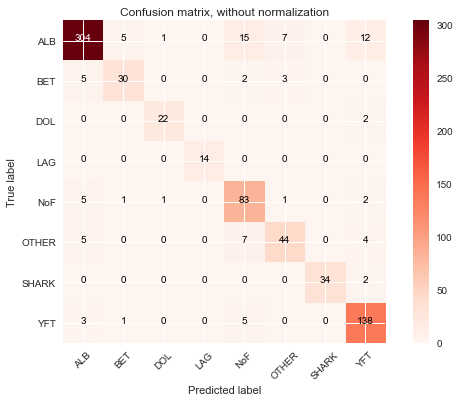

In [ ]:
plt.figure()
plot_confusion_matrix(cf, classes=classes,
                      title='Confusion matrix, without normalization')
plt.show()

**Normalising the confusion matrix and plotting it**

Normalized confusion matrix
[[0.88 0.01 0.   0.   0.04 0.02 0.   0.03]
 [0.12 0.75 0.   0.   0.05 0.08 0.   0.  ]
 [0.   0.   0.92 0.   0.   0.   0.   0.08]
 [0.   0.   0.   1.   0.   0.   0.   0.  ]
 [0.05 0.01 0.01 0.   0.89 0.01 0.   0.02]
 [0.08 0.   0.   0.   0.12 0.73 0.   0.07]
 [0.   0.   0.   0.   0.   0.   0.94 0.06]
 [0.02 0.01 0.   0.   0.03 0.   0.   0.94]]


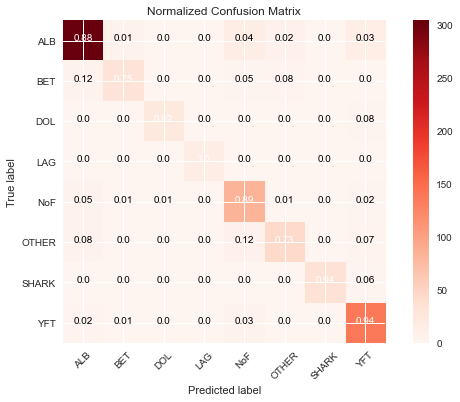

In [ ]:
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cf, classes=classes, normalize = True, title= "Normalized Confusion Matrix")
plt.show()

**We see that the model correctly predicted 669 labels**

In [ ]:
sum(valid_labels==new_labels)

669

**Storing the correct label predictions into a variable**

In [ ]:
correct_labels = (valid_labels == new_labels)

**Creating variables for incorrect index prediction and correct index predictions**

In [ ]:
incorrect_indexes = np.where(correct_labels==False)[0]
correct_indexes = np.where(correct_labels == True)[0]

**Creating a list for storing the paths for validation set images**

In [ ]:
valid_paths = []
for c in classes:
    valid_paths.extend(["new_valid\\"+c+'\\'+name for name in os.listdir("new_valid\\"+c+'\\')])

**Reading an image with a correctly predicted label**

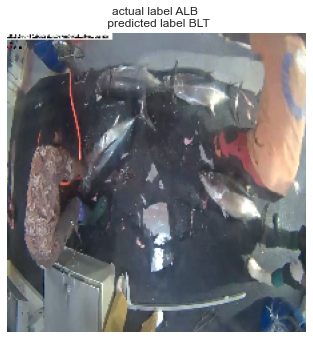

In [ ]:
from keras.preprocessing import image
img_path = valid_paths[0]
img = image.load_img(img_path,target_size=(224,224))
plt.title("actual label {} \n predicted label {}".format('ALB','BLT'))
plt.axis("off")
plt.imshow(img)

**Randomly displaying a set of correctly predicted image labels by the model**

In [ ]:
correct_samples = np.random.choice(correct_indexes,size=5)

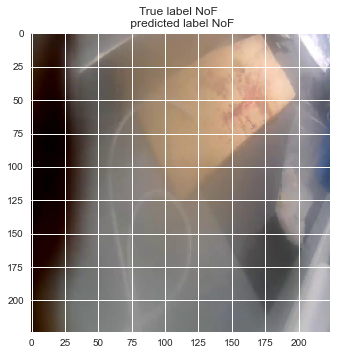

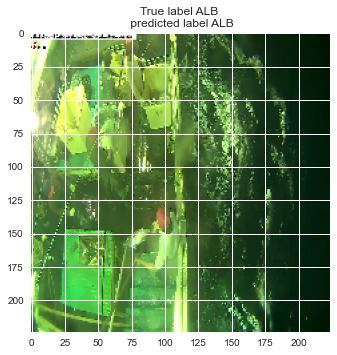

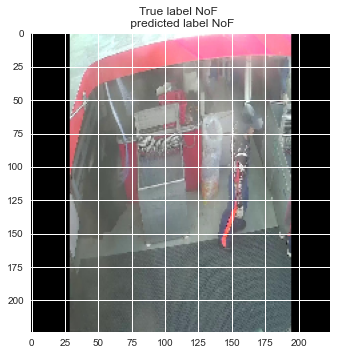

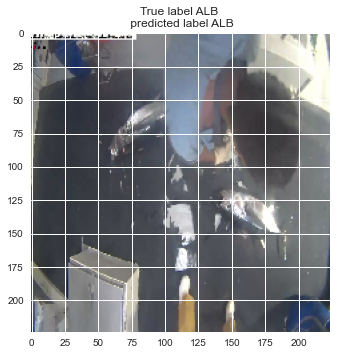

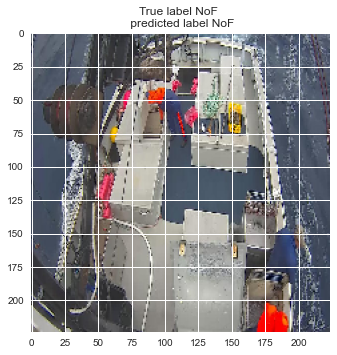

In [ ]:
for i,sample in enumerate(correct_samples):
    img = image.load_img(valid_paths[sample],target_size = (224,224))
    fig = plt.figure()
    plt.title("True label {} \n predicted label {}".format(valid_labels[sample],new_labels[sample]))
    plt.imshow(img)

**Displaying a set of incorrectly predicted image labels by the model**

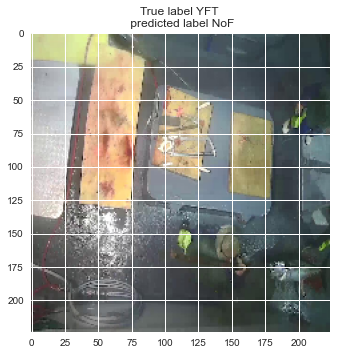

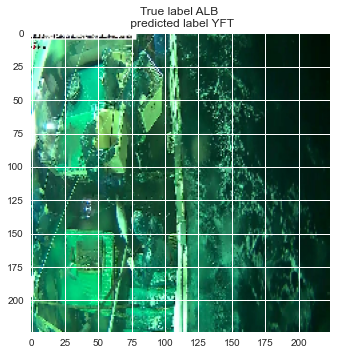

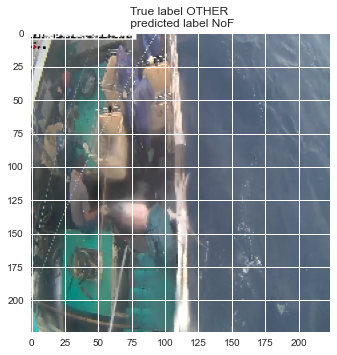

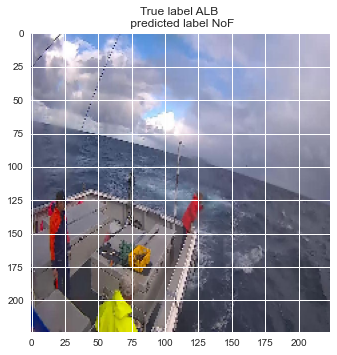

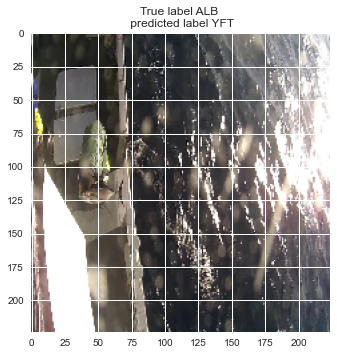

In [ ]:
incorrect_samples = np.random.choice(incorrect_indexes,size = 5)
for i,sample in enumerate(incorrect_samples):
    img = image.load_img(valid_paths[sample],target_size = (224,224))
    fig = plt.figure()
    plt.title("True label {} \n predicted label {}".format(valid_labels[sample],new_labels[sample]))
    plt.imshow(img)

In [ ]:
np_valid_preds.round(2)

array([[0.79, 0.  , 0.  , ..., 0.14, 0.  , 0.05],
       [0.93, 0.  , 0.  , ..., 0.06, 0.  , 0.  ],
       [0.97, 0.02, 0.  , ..., 0.  , 0.  , 0.  ],
       ...,
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 1.  ],
       [0.26, 0.  , 0.  , ..., 0.  , 0.  , 0.64],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 1.  ]], dtype=float32)

**Computing the log loss value for the validaion set labels and predicted labels for the validation set**

In [ ]:
from sklearn.metrics import log_loss

In [ ]:
log_loss(valid_labels,np_valid_preds.round(2))

0.8790305062089027

**Reading the test set features and making a prediction using the VGG16 model**

In [ ]:
test_features = np.load("test_preprocessed.npy")
test_preds = vgg16_model.predict(test_features, batch_size=5, verbose=1)

200/200 [==============================] - 100s 500ms/step


**Displaying a set of correct predictions made by the VGG16 model on the test set features**

<ipython-input-113-4336df2e3eaf>:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fig.add_subplot(1,3,3)


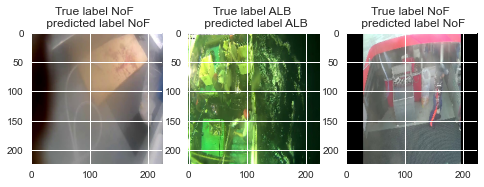

In [ ]:
fig = plt.figure(figsize=(8,10))

fig.add_subplot(1,3,1)
sample = correct_samples[0]
img = image.load_img(valid_paths[sample],target_size = (224,224))
plt.title("True label {} \n predicted label {}".format(valid_labels[sample],new_labels[sample]))
plt.imshow(img)
fig.add_subplot(1,3,2)
sample = correct_samples[1]
img = image.load_img(valid_paths[sample],target_size = (224,224))
plt.title("True label {} \n predicted label {}".format(valid_labels[sample],new_labels[sample]))
plt.imshow(img)
fig.add_subplot(1,3,3)
sample = correct_samples[2]
img = image.load_img(valid_paths[sample],target_size = (224,224))
plt.title("True label {} \n predicted label {}".format(valid_labels[sample],new_labels[sample]))
plt.imshow(img)
fig.add_subplot(1,3,3)
sample = correct_samples[2]
img = image.load_img(valid_paths[sample],target_size = (224,224))
plt.title("True label {} \n predicted label {}".format(valid_labels[sample],new_labels[sample]))
plt.imshow(img)

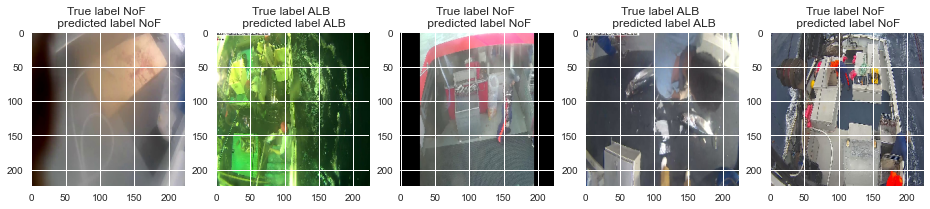

In [ ]:
fig = plt.figure(figsize=(16,12))
for i,sample in enumerate(correct_samples):
    fig.add_subplot(1,5,i+1)
    img = image.load_img(valid_paths[sample],target_size = (224,224))
    plt.title("True label {} \n predicted label {}".format(valid_labels[sample],new_labels[sample]))
    plt.imshow(img)

**Displaying a set of incorrectly predicted fish labels by the model**

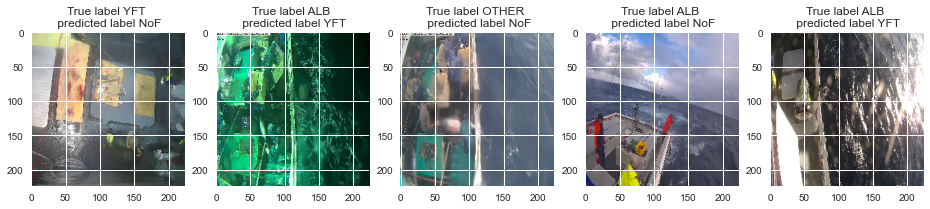

In [ ]:
fig = plt.figure(figsize=(16,12))
for i,sample in enumerate(incorrect_samples):
    fig.add_subplot(1,5,i+1)
    img = image.load_img(valid_paths[sample],target_size = (224,224))
    plt.title("True label {} \n predicted label {}".format(valid_labels[sample],new_labels[sample]))
    plt.imshow(img)

**Conclusion**

* In this notebook, we have implemented a VGG16 model by defining the model parameters, using an ImageDataGenerator function to improve the model robustness and used an EarlyStopping function to reduce the overfitting of the model


* We also evaluated the model performance against our validation and test set features in which we got an accuracy of 88% and a log loss score of 0.879. 


* We also displayed a set of correct and incorrect samples as predicted by the VGG16 model.

**License**

MIT License

Copyright (c) 2020 [ Prasham Shah, Priyanka Bandekar ]

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.